In [1]:
##### This code is from Updated Testing Reddit - No Con- bias (Fictitious Play)-01092022
##### This code replace the big real datanetwork with small sythetic network 
import scipy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import time
import random
from scipy.stats import beta
import pandas as pd
import copy
%matplotlib inline
%run Check_Derivation_of_Two_Opinions.ipynb
#%run pure_strategy_selection.ipynb  #include simple selection algorithm
import scipy.io
import collections
import sys
from itertools import count
from itertools import combinations
from itertools import product
import scipy.optimize
import csv
import os.path

# Game Parameters
# Game_rounds =200 # Rounds + 1- use for printing data
memory = 50

save_path = 'C:/Users/xzhan176/OneDrive/Misinfo Paper/K Nodes - All/Sythetic Network/'


    # Fixed initial condition + memeory = 50

## Mathmatic Functions

In [2]:
# centers the opinion vector around 0\n",
def mean_center(op, n):
    ones = np.ones((n, 1))
    x = op - (np.dot(np.transpose(op),ones)/n) * ones
    return x
    
# compute number of edges, m\n
def num_edges(L, n):
    m = 0
    for i in range(n):
        for j in range(n):
            if i > j and L[i,j] < 0:
                m += 1            
    return m

# Compute number of possible actions
def len_actions(k, n):
    # create all combination of K opinions
    max_option = [0, 1]
    k_opinions =[]
    for max_option in product(max_option, repeat=k):
        k_opinions.append(max_option)   # Append all k opinion combinations

    len_kops = len(k_opinions) # - number of combinations exist
    # Horizontal length of all possible actions
    all = list(range(n))    # for all nodes
    h = len(list(combinations(all,k)))*len_kops
    return h


# maximizing polarization only: \\bar{z}^T \\bar{z}   
def obj_polarization(A, L, op, n):
    op_mean = mean_center(op, n)
    z_mean = np.dot(A, op_mean)
    return np.dot(np.transpose(z_mean), z_mean)[0,0] 

# def obj_polarization_1(A, L, op, n):  #z_mean is the same as s_mean - according to Stanford paper theory
#     z = np.dot(A, op) 
#     z_mean = mean_center(z, n)
#     return np.dot(np.transpose(z_mean), z_mean)[0,0] 

# Calculate innate polarization
def obj_innate_polarization(s, n):  
#     np.set_printoptions(precision=5)
    op_mean = mean_center(s, n)
    return np.dot(np.transpose(op_mean), op_mean)[0,0]

np.set_printoptions(precision=5)

### 1. Import Network

In [3]:
#################### Import Sythetic Network Data
df = pd.read_csv (save_path+'data/Adjacency Matrix.csv', header=None)
G = np.array(df[df.columns[:]])
# print(G)
df1 = pd.read_csv(save_path+'data/Innate Opinion.csv', header = None)
s = np.array(df1[df1.columns[:]])
# print(G.shape)

# Set n according to the data
n = len(s[:])
# print(n)

20


<Figure size 2000x2000 with 0 Axes>

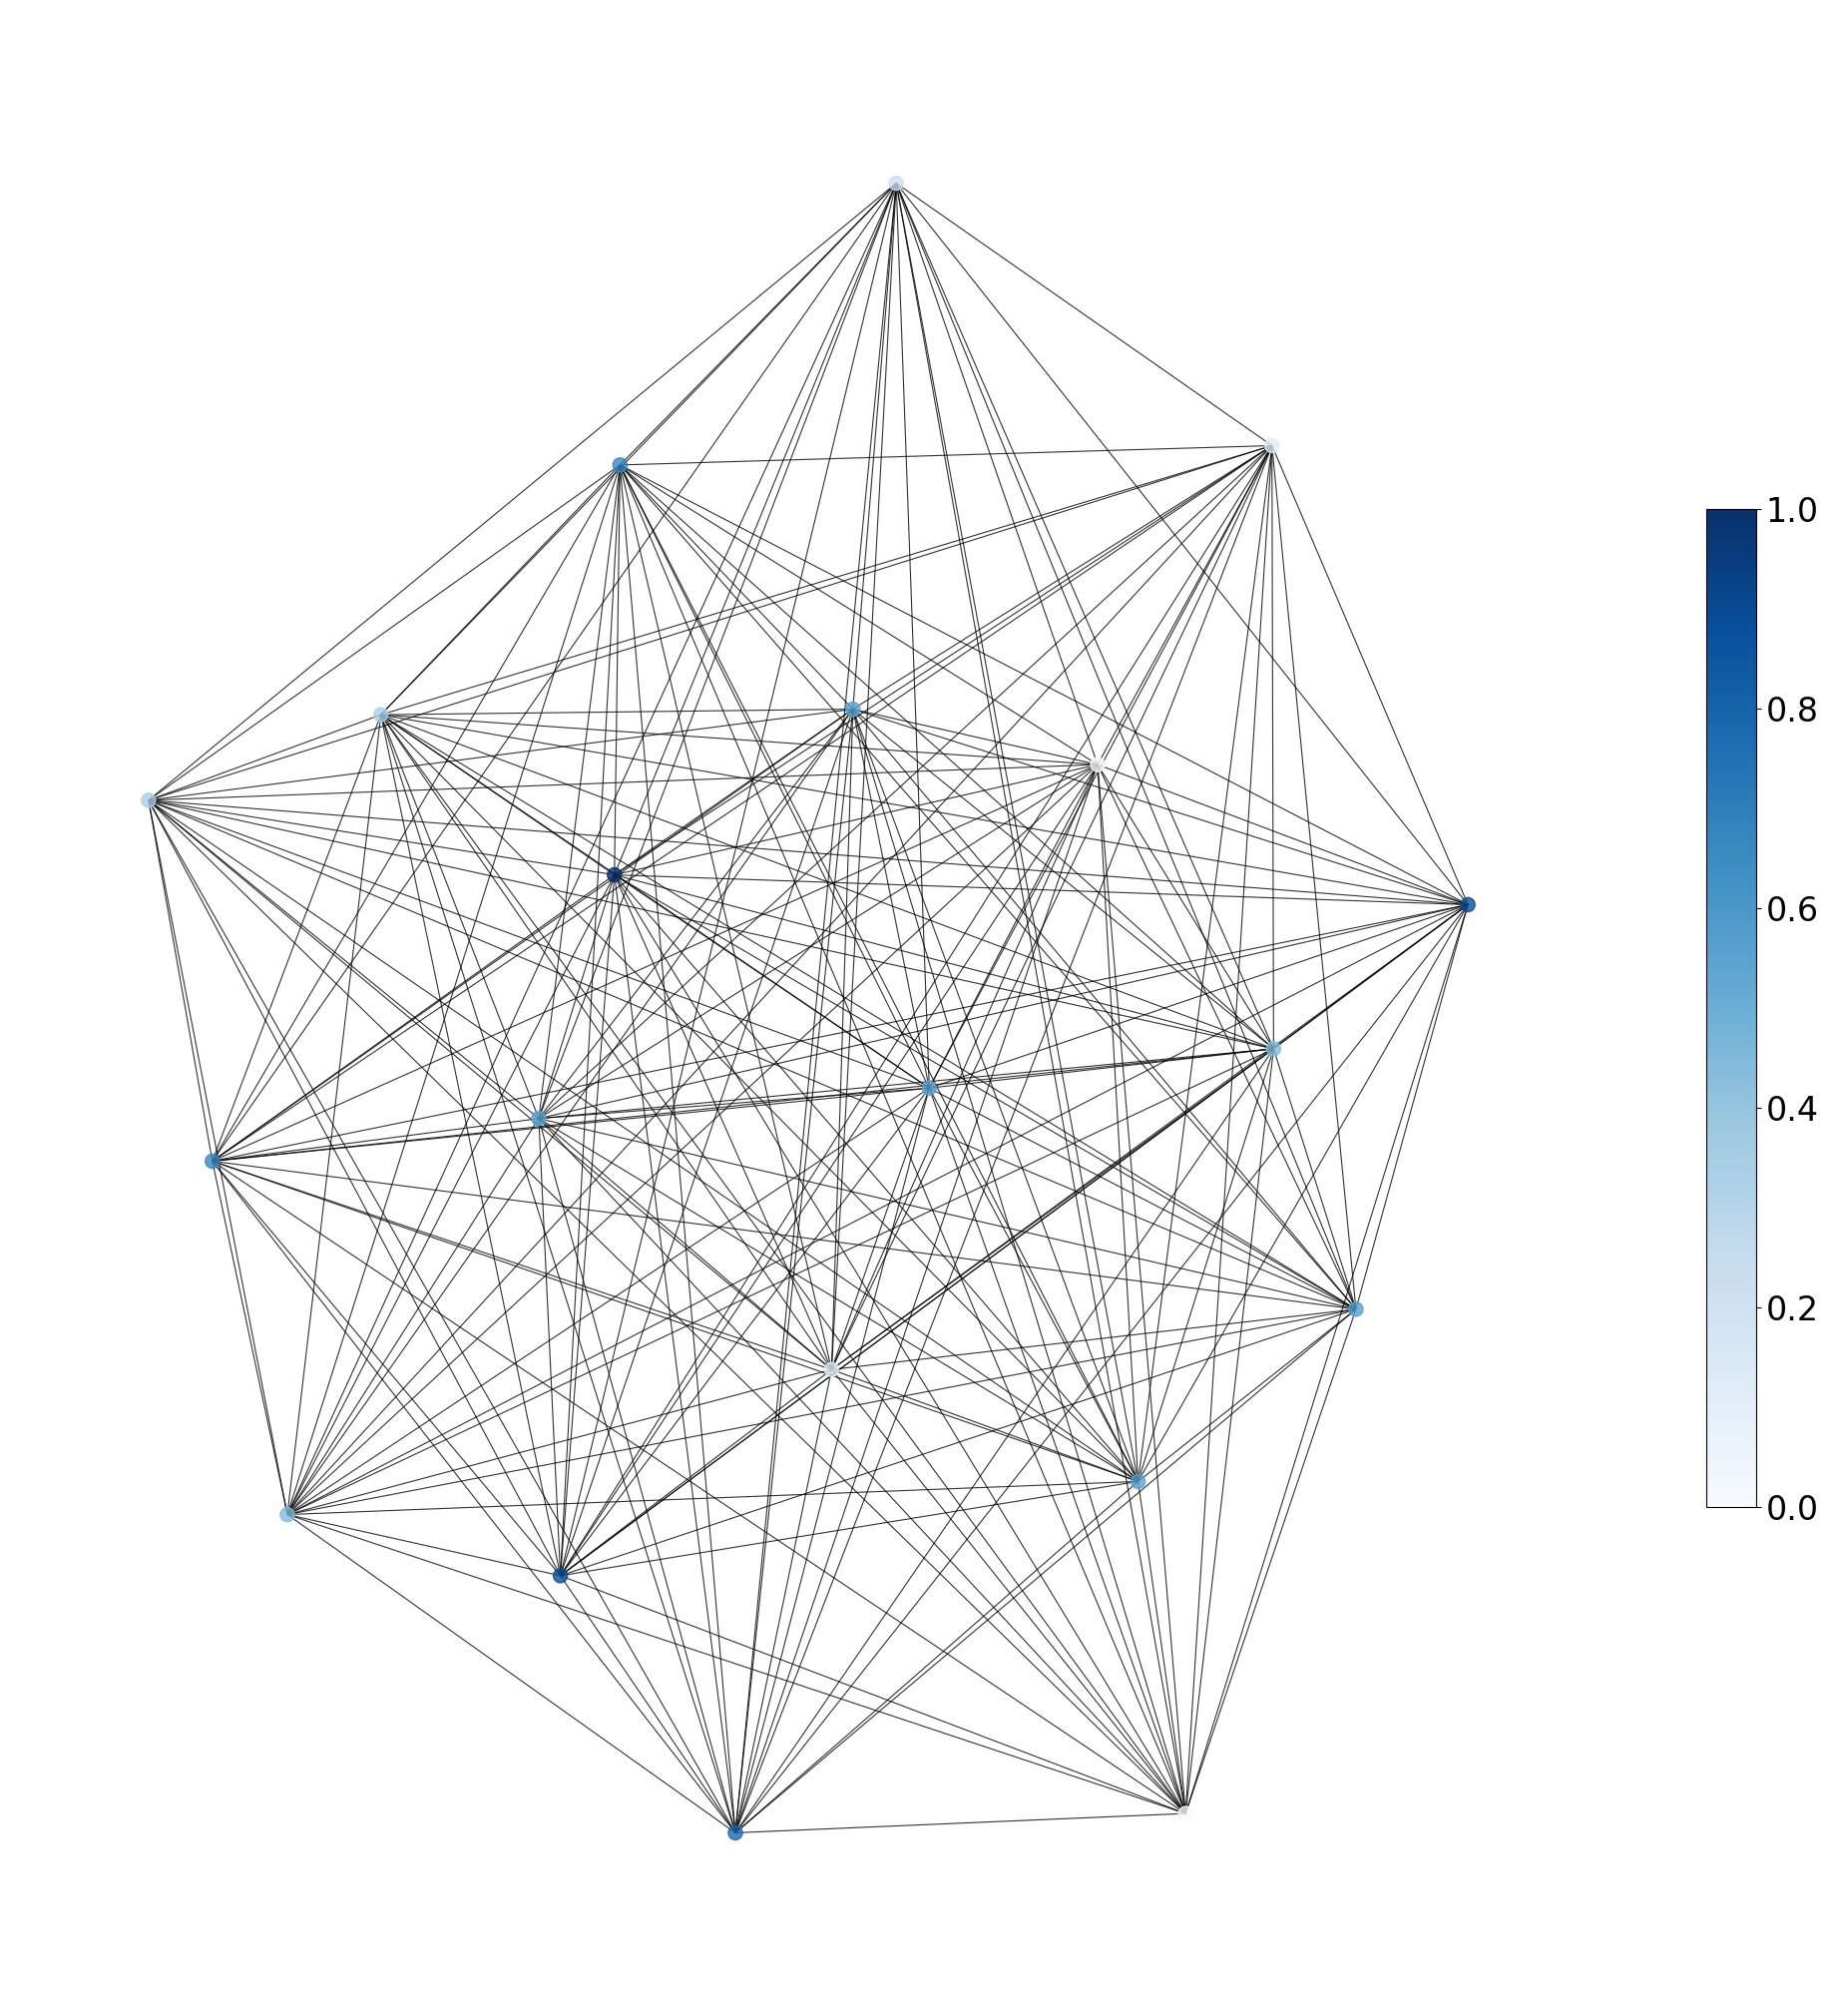

In [16]:
################## Process the Network Data
L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory
m = num_edges(L, n)                    # call the function to calculate the number of edges
# what the twitter graph looks like 
nxG = nx.from_numpy_matrix(G)          
#plt.figure(figsize=(20, 20))
# nx.draw(nxG)
columnsum_ij = np.sum(A, axis=0)
# print(columnsum_ij)
#___________________________________________________

# # what the twitter graph looks like 
# s_use = s.flatten()   # Convert array to a list for later operation
# s_use = s_use.tolist()
# new_s = [i * 30 for i in s_use]
# df = pd.DataFrame(new_s, columns=['Opinion']) #create a datafram with index at column 1, opinion at column 2
# #_______________________________________________________

# nxG = nx.from_numpy_matrix(G)   
# # nxG = nx.relabel_nodes(nxG, mapping)      
# plt.figure(figsize=(20, 20))


# def node_edge(G, n):
#     edges =[]
#     for v in range(n):
#         a = np.array(np.nonzero(G[v])[0])
#         edge = len(a)
# #         print(edge)
#         edges.append(edge)
        
#     return edges

# node_edges = node_edge(G, n)
# # print(node_edges)

# node_sizes =[]
# for i in node_edges:
#     node_size = 1/i*2000
#     node_sizes.append(node_size)

# min_equi = []
# max_equi = []
# # Create node color
# color_map = []
# for node in nxG:
#     if node in min_equi:
#         color_map.append('orange')
#     elif node in max_equi:
#         color_map.append('red')
#     else:
#         color_map.append('grey')
# # print(node_sizes)
# #-_______________________________________
# # what the twitter graph looks like 
# nxG = nx.from_numpy_matrix(G)          
# plt.figure(figsize=(20, 20))

# # Fix seed - fix network shape
# my_pos = nx.spring_layout(nxG, seed = 2)
# nx.draw(nxG, pos= my_pos, with_labels= False, node_color=df['Opinion'].astype(int),cmap=plt.cm.Blues, node_size= node_sizes, edge_color='black', width=0.8, font_color='black',font_size=26, font_weight='bold', alpha=0.8)
# #nx.draw(nxG, pos = my_pos, with_labels=False, node_color=color_map, node_size= node_sizes, edge_color='grey', width=0.5, font_color='white',font_size=9, font_weight='bold')
# sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin = 0, vmax=1))
# cbar = plt.colorbar(sm, shrink = 0.5)
# tick_font_size = 24
# cbar.ax.tick_params(labelsize=tick_font_size)
# plt.show()


In [13]:
def network_anl(s,n,G,agent):

    print(str(agent)+' opinion: ' + str(s[agent]))
    print(str(agent)+' neighbors: '+ str(np.nonzero(G[agent])))

    s_aa = s[:, 0]
    my_dict = {index: value for index, value in enumerate(s_aa)}
    sorting_s = sorted(my_dict.items(), key=lambda x:x[1])
    sorted_S = dict(sorting_s)

    temp = list(sorted_S.items()) 
    res = [idx for idx, key in enumerate(temp) if key[0]==agent]
    # printing result 
    print("Opinion rank of this agent is : " + str(res))



    #print("___________________Max Analyze__________________________________________")
    nxG = nx.from_numpy_matrix(G) 
    # G = nx.karate_club_graph()
    print("_______________Degree Centrality___________________")  
    deg_centrality = nx.degree_centrality(nxG)
    sortedDict = sorted(deg_centrality.items(), key=lambda x:x[1])
    converted_dict = dict(sortedDict)
    temp1 = list(converted_dict.items()) 
    res1 = [idx for idx, key in enumerate(temp1) if key[0]==agent]
    print("rank of this agent is : " + str(res1))
    print(converted_dict[agent])

    # print(converted_dict)
    print("                           ")
    print("_______________Closeness Rank________________________")
    close_centrality = nx.closeness_centrality(nxG)
    sortedDict1 = sorted(close_centrality.items(), key=lambda x:x[1])
    converted_dict1 = dict(sortedDict1)
    temp2 = list(converted_dict1.items()) 
    res2 = [idx for idx, key in enumerate(temp2) if key[0]==agent]
    print("rank of this agent is : " + str(res2))
    print(converted_dict1[agent])
    # print(converted_dict1)
    print("                           ")
    print("_______________Page Rank_____________________________")
    pr = nx.eigenvector_centrality(nxG)
    sortedDict3 = sorted(pr.items(), key=lambda x:x[1])
    converted_dict3 = dict(sortedDict3)
    temp3 = list(converted_dict3.items()) 
    res3 = [idx for idx, key in enumerate(temp3) if key[0]==agent]
    print("rank of this agent is : " + str(res3))
    print(converted_dict3[agent])
    # print(converted_dict3)

    print("                           ")

    def gap(op, n):
        ones = np.ones((n, 1))
        x = op - (np.dot(np.transpose(op),ones)/n) * ones
        return abs(x)

    gap = gap(s,n)
    my_gap = {index: value for index, value in enumerate(gap)}
    sorting_gap = sorted(my_gap.items(), key=lambda x:x[1])
    sorted_gap = dict(sorting_gap)
    #print(sorted_gap)
    temp4 = list(sorted_gap.items()) 
    res4 = [idx for idx, key in enumerate(temp4) if key[0]==agent]
    print("Agent's opinion gap to mean opinion is ranked as: " + str(res4))

    
    print("___________________Max Analyze__________________________________________")
nxG = nx.from_numpy_matrix(G) 
# G = nx.karate_club_graph()
print("_______________Degree Centrality_____________________________")  
plt.figure(figsize =(15, 15))
deg_centrality = nx.degree_centrality(nxG)
sortedDict = sorted(deg_centrality.items(), key=lambda x:x[1])
converted_dict = dict(sortedDict)
print(converted_dict)
print("                           ")
print("_______________Closeness Rank_____________________________")
close_centrality = nx.closeness_centrality(nxG)
sortedDict1 = sorted(close_centrality.items(), key=lambda x:x[1])
converted_dict1 = dict(sortedDict1)
print(converted_dict1)
print("                           ")
print("_______________Page Rank_____________________________")
pr = nx.eigenvector_centrality(nxG)
sortedDict3 = sorted(pr.items(), key=lambda x:x[1])
converted_dict3 = dict(sortedDict3)
print(converted_dict3)

print("                           ")

def gap(op, n):
    ones = np.ones((n, 1))
    x = op - (np.dot(np.transpose(op),ones)/n) * ones
    return abs(x)

gap = gap(s,n)
my_gap = {index: value for index, value in enumerate(gap)}
sorting_gap = sorted(my_gap.items(), key=lambda x:x[1])
sorted_gap = dict(sorting_gap)
print(sorted_gap)


    

_______________Degree Centrality_____________________________
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0}
                           
_______________Closeness Rank_____________________________
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0}
                           
_______________Page Rank_____________________________
{0: 0.22360679774997896, 1: 0.22360679774997896, 2: 0.22360679774997896, 3: 0.22360679774997896, 4: 0.22360679774997896, 5: 0.22360679774997896, 6: 0.22360679774997896, 7: 0.22360679774997896, 8: 0.22360679774997896, 9: 0.22360679774997896, 10: 0.22360679774997896, 11: 0.22360679774997896, 12: 0.22360679774997896, 13: 0.22360679774997896, 14: 0.22360679774997896, 15: 0.22360679774997896, 16: 0.22360679774997896, 17: 0.22360

<Figure size 1500x1500 with 0 Axes>

In [12]:
agent = 6
network_anl(s,n,G,agent)

6 opinion: [0.46113]
6 neighbors: (array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19], dtype=int64),)
Opinion rank of this agent is : [8]
_______________Degree Centrality___________________
rank of this agent is : [6]
1.0
                           
_______________Closeness Rank________________________
rank of this agent is : [6]
1.0
                           
_______________Page Rank_____________________________
rank of this agent is : [6]
0.22360679774997896
                           
Agent's opinion gap to mean opinion is ranked as: [0]


### 2. Equilibrium & Polarization 
$$P(z) = z ^T * z $$


In [6]:
# op = s
# y = mean_center(s,n)
# # print(y)
# innat_pol = np.dot(np.transpose(y), y)[0,0] 
# print('Innate_polarization:')
# print(innat_pol)

# # Test equilibrium polarization
# equ_pol = obj_polarization(A, L, s, n)
# print('Equi_polarization:')
# print(equ_pol)

# di = equ_pol-innat_pol
# print("Difference:")
# print(di)

### 3. Helper Functions

In [7]:
def k_random_play_1(s,n,k,max_touched):  # player randomly choose an agent and randomly change the agent
    
    op = copy.copy(s)
#     max_opi_option = random.uniform(0, 1)   # options that maximizer have
    
    (node_sets,len_nodesets) = creat_available_comb(n,k,max_touched)

    v_n = random.randint(0,len_nodesets-1)  # randomly select an agent index
    v_list = node_sets[v_n]
    
    new_op_list = []
    for i in range(k):
        #new_op = random.uniform(0, 1)  # randomly select an opininon between 0 and 1
        new_op = 0.5
        new_op_list.append(new_op)
   
    new_op_list = tuple(new_op_list)
#     print('Nodes, opinions')
#     print(v_list,new_op_list)
    op = change_k_innate_opinion(s, v_list, new_op_list)
   # print("    "+"Agent" + str(v) +" 's opinion " + str(old_opinion) + " changed to "+ str(new_op))
    por = obj_polarization(A, L, op, n)
#     print("Network reaches steady-state Polarization: " + str(por))
#     print('Should be restored')
#     print(op)
    return (v_list, new_op_list, por)





In [8]:
# (v, new_op_list, por) =k_random_play_1(s,n,k,max_touched)

In [9]:
# min_touched = [1]

# (all_sets, k_opinions, len_kops) = def creat_all_comb(k)

########### create all combination
def creat_all_comb(n, k):
########### create all combination of K opinions
    max_option = [0, 1]
    k_opinions =[]
    k_opinions = [max_option for max_option in product(max_option, repeat=k)]  # - Append all k opinion combinations
    # slower version of k_opinions
#     for max_option in product(max_option, repeat=k):
#         k_opinions.append(max_option)     
########### create all combination of K nodes

    all = list(range(n))    # all nodes 
    all_sets = list(combinations(all,k)) # all possible actions

    return(all_sets, k_opinions)


########### create available combination of K nodes
def creat_available_comb(n,k,touched):
    all = list(range(n))    # all nodes 
    C1 = [x for x in all if x not in touched]  # for the nodes that Min/Maximizer has not touched
    node_sets = list(combinations(C1,k)) # - all combination of k nodes
#     print('K nodes')
#     print(node_sets)
    len_nodesets = len(node_sets) # - # of combination of k nodes
#     print(len_nodesets) 
    return (node_sets,len_nodesets)

In [10]:
# max_touched = [0]
# v2 = [0]
# k = 2
# node_set = [1,2]
# k_opinion = [0,0]

### Mixed Strategy Payoff


In [11]:
np.set_printoptions(precision=3)
def make_k_payoff_row(op1, h, v2): #op1 here is only changed by Min
    payoff_row = np.zeros(h)
    (node_sets, k_opinions) = creat_all_comb(n, k)
    
    column = 0 
    i = 0
    for nodes in node_sets:     # i - which set of nodes option
#         print('nodeset'+ str(i))
        i = i + 1
        j = 0
        for ops in k_opinions: # tuple index - select one combinatio of opinions
#             print('opset'+ str(j))
#             j = j + 1
            op2 = change_k_innate_opinion(op1, nodes, ops) # op2 has changed by both min and max now
            check =  any(node in nodes for node in v2)     
            
 # when v1 == v2, the polarization should be negative for max, infinet for min. 
 # Replace the the column_index of agent v2 with 0 for max                   
            if check is False:    #if v1 != v2
                # calculate the payofflarization
                payoff = obj_polarization(A, L, op2, n) # calculate the payofflarization
                payoff_row[column] = payoff
                column = column + 1  
#                 print(payoff_row) 
            else:                #if v1 == v2   
                payoff_row[column] = 10000  # use to avoid min and max choose the same agent
                column = column + 1  
#                 print(payoff_row)   
            
#     print(payoff_row)        


    return payoff_row    

In [12]:
# payoff_row = make_k_payoff_row(s, h, v2)


### Minimizer Mixed Strategy

In [13]:
def change_k_innate_opinion(s, node_set, k_opinion): # node_set - 1 set  k_opinion- 1 set
    op =  copy.copy(s) # make a copy of the innate opinion array 

    for j in range(k):
        b = node_set[j] # b - agent index
        op[b]=k_opinion[j]   # f - index of which opinion combination
        
    return op



In [14]:
# node_set = [1,2]
# k_opinion = [0,0]
# op = change_k_innate_opinion(s, node_set, k_opinion)
# print(op)

In [15]:
# Calculate polarization of minimizer's Mixed Strategy
def mixed_K_min_polarization(s,v2,k_opinion,fla_max_fre):

    op1 = change_k_innate_opinion(s, v2, k_opinion) # only updated by minimizer's current change
    # calculate the polarization with both min(did above) and max's action(in make_payoff_row)
    payoff_row = make_k_payoff_row(op1, h, v2)  # the vector list out 2*n payoffs after min's action combine with 2*n possible max's actions
#     print('payoff_row')
#     print(payoff_row)
    #calculate fictitious payoff - equi_min  
    payoff_cal = payoff_row * fla_max_fre # fla_max_fre recorded the frequency of each maximizer's action, frequency sum = 1
                                             # payoff (2*n array) * maximizer_action_frequency (2*n array)
#     print('payoff_cal')
#     print(payoff_cal)
    mixed_pol = np.sum(payoff_cal) # add up all, calculate average/expected payoff
#     print('Mixed_pol')
#     print(mixed_pol)

    # Replace the the column_index of agent v2 with -100 for max

    payoff_row = [-10000 if ele == 10000 else ele for ele in payoff_row]


    return (mixed_pol,payoff_row)


In [16]:
# (mixed_pol,payoff_row) = mixed_K_min_polarization(s,v2,max_opinion,fla_max_fre)

In [17]:
############################################ k Min_opinion - Python Package Solve  ################################
# k = 2
# v2=[1,2]


############## Create the sum_term - exclude selected nodes 
#M_1= sum_term - term_out    # numerator
def sum_rest(n, op, v2):
    # Reshape opinion array
    op = np.reshape(op, (n,1))
    
    E_new =np.array([1/n] * n *n)  
    E_new = np.reshape(E_new, (n,n)) # create a n*n matrix with all elements 1
    #A_new = np.reshape(A, (n,n))
    A_new = copy.copy(A)
    A_temp=A_new-E_new
    M_new_temp=A_temp@op
    def sumFunction(x):
        s_i = op[x]*A_temp[x]
        return s_i
    np.sum(A, axis=0)   
    Out_term = np.sum([sumFunction(x) for x in v2],axis=0)  
    Out_term = np.reshape(Out_term, (n,1))
    M_rest = np.transpose(M_new_temp-Out_term)
#     print('M')
#     print(M_rest)
    return M_rest

############## Derivate min_opinions - using above result#####################################
def k_derivate_s(v2,k,n,M): 
        # k - # of selected nodes
        # V2 - selection list(k nodes) of minimier
         #  take the node index from selection list
         #  it's also the column index for these two nodes
        # op - n*1 innate opinion array that updated by maximizer
        # A - n*n adjacency matrix 

    # create a parameter array with all 1/n 
    c =np.array([1/n] * n)   
    #c = np.reshape(c, (n,1))

    ############## Create left side of '=' matrix
    def leftFunction(x,y):
        a_i = np.transpose(A[x]-c)@(A[y]-c)
        return [a_i]
    a = np.concatenate([leftFunction(x,y) for y in v2 for x in v2]) 
    a = np.reshape(a, (k,k))
#     print('a')
#     print(a)
    ############ Create right side of '=' matrix
    def rightFunction(x, M):
        Mi = np.dot(M, (A[x]-c))
        return -Mi  
    b = np.concatenate([rightFunction(x,M) for x in v2])   
#     print('b')
#     print(b)
    result = np.linalg.solve(a, b)
#     print(a,b)   
    return result


# %run Check_Derivation_of_Two_Opinions.ipynb
# M_1 = sum_rest(n, s, v2)

# print('Testing sample - 3 results should be the same:')
# result = k_derivate_s(v2,k,n,M_1)
# print('result')
# print(result)
    
# print('check result')
# (x,y) = py_pack(A, s, n, v2)
# (si,sl) = deriv_sty(A, s, n, v2)

In [18]:
def min_k_mixed_opinion(s, n, v2, fla_max_fre):
    
    weight_op = 0
    weight_M = 0
    # loop for each max_action(in total 2*n) 
    (all_sets, k_opinions) = creat_all_comb(n, k)

    len_kops = len(k_opinions)
    for column in range(h):

        if fla_max_fre[column] !=0:
#             print('column'+ str(column))
#             print('Probability')
#             print(round(fla_max_fre[column],3))

            if column > k:
                nodeset_index = int(column/len_kops)
                opset_index = column%len_kops
#                 print("nodeset_index, opset_index")
#                 print(nodeset_index, opset_index)
            else:
#                 print('less than 1')
                nodeset_index = 0
                opset_index = column
#                 print("nodeset_index, opset_index")
#                 print(nodeset_index, opset_index)
                
            # Calculating Max's action at this column
            v1 = all_sets[nodeset_index]
            max_opinion = k_opinions[opset_index] 
#             print('v1,max_opinion')
#             print(v1,max_opinion)
            op1 = change_k_innate_opinion(s, v1, max_opinion) # change innate opinion by max action
#             print('check if max update the opinion')
#             print(op1)
   # Derivate optimal Min's opinion for nodeset v2
            M_rest = sum_rest(n, op1, v2)  #{sum}{j}(s_j(h_j -c))  - rest of terms

            weight_M = weight_M + fla_max_fre[column]*M_rest # {sum}{v} p_v * M
#             print('M')
#             print(M_rest)
#     print('M_SUM')
#     print(weight_M)
    # Got optimal Min's opinion for v2
    k_opinion = k_derivate_s(v2,k,n,weight_M) # give a set of k weighted opinions
    (mixed_por, payoff_row) = mixed_K_min_polarization(s, v2, k_opinion,fla_max_fre)
    
#     print('Weighted polarization')
#     print(mixed_por)
    if any(x < 0 for x in k_opinion):
        print('Min_opinion less than 0') # min_opinion should be in the range (0,1)
        print(k_opinion)
        sys.exit()
        
    return(k_opinion,payoff_row,mixed_por)  



In [19]:
# ##################### Try to make above for loop as matrix multiplication #############################
# from numpy.random import normal
# fla_max_fre =normal(size=h)
# M = normal(size=n)
# M = np.transpose(M)
# print(fla_max_fre)

In [20]:
# Minimizer search: Go through each agent 

def mixed_choose_min_vertex(s, n, v1, max_opinion, max_touched, fla_max_fre):
    # current polarization that changed by maximizer, "innate" objective that min start with
    op = change_k_innate_opinion(s, v1, max_opinion) 
#     print('Check if op has been updated by Maximizer')
#     print(op)
    min_por = obj_polarization(A, L, op, n) #min_por- set a standard to compare with pol after min's action
    maxup_por = min_por # store innate max updated polarization
#     print('check maxup por')
#     print(maxup_por)
#     payoffs = []    # create an empty list to store all polarizations   
    champion = (None, None, 0, None)  # assume the best action is champion

    (node_sets, len_nodesets)= creat_available_comb(n,k,max_touched)
    
    for v2 in node_sets:  #---- now v2 is a set of nodes
#         print('_________________________________')
#         print('Min start with agent '+ str(v2) )

        (changed_opinion, payoff_row, por) =  min_k_mixed_opinion(s, n, v2, fla_max_fre) # find the best new_op option 
                                                                                         # input innate opinion array s
#         print('Weighted polarization')
#         print(str(por)+'...')


        if por < min_por:  # if the recent polarization is smaller than the minimum polarization in the history
            min_por = por
            champion = (v2, changed_opinion, payoff_row, min_por)
                            # update the recent option as champion  
#         else:
#             print('Innate polarization is smaller than Min action')
           
    return (champion)  # find the best minimizer's action after going through every new_op option of every agent


In [21]:
# champion = mixed_choose_min_vertex(s, n, v1, max_opinion, max_touched, fla_max_fre)

In [22]:
# (all_sets, k_opinions) = creat_all_comb(n, k)
# print('all_sets,k_opinions')
# print(all_sets,k_opinions)


In [23]:
####Op has been updated by maximizer, fla_max_fre includes max's hisotry, so minimizer react to the innate op after that
def mixed_min_play(s,v1,max_opinion,n, max_touched,fla_max_fre): 

#     print('_______________________')
#     print('Minimizer Play')
#     print('Only 1 opinion changed')
#     print(op)
    
    min_champion = mixed_choose_min_vertex(s, n, v1, max_opinion, max_touched, fla_max_fre)
    (v2, min_opinion, payoff_row, min_pol) = min_champion
    
    if v2 == None:    # if minimizer cannot find a action to minimize polarization after maximizer's action
        print('Minimizer fail')

    else:
#         print("                                ")
#         print("Minimizer finds its target agents:")

        # Store innate_op of the min_selected k vertex
        old_opinion_min = [s[i] for i in v2]

#         print("    "+"Agent" + str(v2) +" 's opinion " + str(old_opinion_min) + " changed to "+ str(min_opinion))
#         print('fla_max_fre')
#         print(fla_max_fre[np.nonzero(fla_max_fre)])


#         print("Payoff row")
#         print(payoff_row)
#         print("Network reaches steady-state Polarization: " + str(min_pol))

    return (v2, payoff_row, min_opinion, min_pol)                 

In [24]:
# # v1 = [1]
# # max_opinion=[0]
# (v2, payoff_row, min_opinion, min_pol) = mixed_min_play(s,v1,max_opinion,n, max_touched,fla_max_fre)

### Maximizer Mixed Strategy

In [25]:
####Op has been updated by minimizer, fla_min_fre includes min's hisotry, so maxmizer react to the innate op after that
def k_max_polarization(payoff_matrix,column,fla_min_fre):

    # create payoff matrix for maxmizer
    payoff_vector = payoff_matrix[:,column]
#     print('payoff_vector')
#     print(payoff_vector)
    if any(i> 10 for i in payoff_vector) >10:
        print('Error in Payoff Matrix')
        sys.exit
    #calculate fictitious payoff - equi_max  
#     print('fla_min_fre')
#     print(fla_min_fre)
    payoff_cal = payoff_vector * fla_min_fre #payoff * frequency

    mixed_pol = np.sum(payoff_cal) # add up

    return mixed_pol


In [26]:
# mixed_pol = k_max_polarization(payoff_matrix,column, fla_min_fre)

In [27]:
# # pass on the innate opinion that has been changed by minimizer
def max_k_play(payoff_matrix, op, n, k, fla_min_fre, min_touched): # - op1 - innate opinion that has been changed by minimizer
    (all_sets, k_opinions) = creat_all_comb(n, k)
    len_kops = len(k_opinions)
    (node_sets,len_nodesets) = creat_available_comb(n,k,min_touched)
    
    ############ start producing changes ###########
    all_por = np.zeros(h)
#     print('all_por')
#     print(all_por)
    count = 0

    for i in node_sets:  # for each available k nodes
#         print('node_set')
#         print(i)
        k_nodes_index = all_sets.index(i) # map the index of this nodeset located in all lists
#         print('Index')
#         print(k_nodes_index)
        for f in range(len_kops):         # for each opinion combination 
            column = k_nodes_index*len_kops + f  # locate the column in payoff row- all combinations
#             print('column')
#             print(column)
            #por = obj_polarization(A, L, s, n)
            por= k_max_polarization(payoff_matrix, column, fla_min_fre) # calculate mixed polarization
            all_por[column] = por

    # ############# best action ##########
#     print('all_por')
#     print(all_por)
    column = np.argmax(all_por) # Index of maximum polarization - in all actions
#     print('len_kops,column')
#     print(len_kops, column)
    # print(all_por)
    # print(a)

    if column > k:
        nodeset_index = int(column/len_kops)
        opset_index = column%len_kops
#         print("nodeset_index, opset_index")
#         print(nodeset_index, opset_index)
    else:
#         print('less than 1')
        nodeset_index = 0
        opset_index = column

    v1 = all_sets[nodeset_index]
    max_opinion = k_opinions[opset_index] 
    # print(v1,max_opinion)
    # print(all_sets)

    # # Find innate opinion of k nodes - Comment - testing use
    old_opinion_max = [s[i] for i in v1]
#     print("                                ")
#     print("Maximizer finds its target "+str(k)+ " agent:")

    ## check if agent's opinionis is changed or not
#     print("    "+"Agent" + str(v1) +" 's opinion " + str(old_opinion_max) + " changed to "+ str(max_opinion))
#     print("Network reaches steady-state Polarization: " + str(np.max(all_por)))

    return(v1, max_opinion, np.max(all_por), column)



In [28]:
def k_random_play(s,n,k):  # player randomly choose an agent and randomly change the agent
    
    op = copy.copy(s)
    
    ########### create all combination of K nodes
    all = list(range(n))    # for all nodes
#     print('all')
#     print(all)
    # - all combination of k nodes
    node_sets = list(combinations(all,k)) 
#     print('node_sets')
#     print(node_sets)
    len_nodesets = len(node_sets) 
#     print('what happened')
#     print(len_nodesets)
    v_index = random.randint(0,len_nodesets-1)  # randomly select an agent index
    v_list = node_sets[v_index]
    
    ########### create all combination of K opinions
    max_option = [0, 1]
    k_opinions =[]
    k_opinions =[max_option for max_option in product(max_option,repeat=k)]  # Append all k opinion combinations
    len_kops = len(k_opinions) # - number of combinations exist
    op_index = random.randint(0,len_kops-1) # randomly select index for an OPINION list 
    new_op = k_opinions[op_index]  # randomly select an opininon list(0 and 1) to update the opinion array
#     print('Nodes, opinions')
#     print(v_list,new_op)
#     print(new_op)
    op = change_k_innate_opinion(s, v_list, new_op)

   # print("    "+"Agent" + str(v) +" 's opinion " + str(old_opinion) + " changed to "+ str(new_op))
    
    por = obj_polarization(A, L, op, n)
    
    column = len_kops*v_index + op_index
#     print("Network reaches stead_state Polarization: " + str(por))

    return (v_list, new_op, por, column)


In [29]:
# k = 3
# (v_list, new_op, por, column) = k_random_play(s,n,k)
# (v1, max_opinion, max_por , column) = max_k_play(payoff_matrix, op, n, k, fla_min_fre, min_touched)

In [30]:
# print(payoff_matrix)
# payoff_matrix.shape

## 5. Innate Op and Game

# Fictitious Play Start !


In [31]:
# op = s
# y = mean_center(s,n)
# # print(y)
# innat_pol = np.dot(np.transpose(y), y)[0,0] 
# print('Innate_polarization:')
# print(innat_pol)

# # Test equilibrium polarization
# equ_pol = obj_polarization(A, L, op, n)
# print('Equi_polarization:')
# print(equ_pol)

# di = equ_pol-innat_pol
# print("Difference:")
# print(di)



In [32]:
# # Game Parameters
# Game_rounds =200 # Rounds + 1- use for printing data
# memory = 50

# Game Preparation
def push(obj, element):
    if len(obj) >= memory:
        dif = len(obj) - memory
        obj.pop(dif)
    obj.extend(list(element))
    return obj


In [37]:
def excute(h, k, Game_rounds):
    # Preparation for the game
    op = copy.copy(s)
    payoff_matrix = np.empty((0, h), float)
    max_history = np.zeros(h, int)  # n*2 matrix, agent i & opinion options
    min_history = []  # append a list of (agent i, min_opinion), min_opinion can be any value
    #     print(type(min_history))

    max_history_last_100 = np.zeros(h, int) 
    min_history_last_100= []

    max_touched = []
    min_touched = []
    min_touched_all = []
    min_touched_last_100 =[]
#     print('max_touched')
#     print(max_touched)
#     print('min_touched')
#     print(min_touched)


    # Game start from maximizer random play
#     print('Maximizer first selection')
    (v1, max_opinion, max_pol, column) = k_random_play(s,n,k)
    #(v1, max_opinion, max_pol) = random_play(op,n)   # Maximizer does random action 
    #(v1, max_opinion, max_pol) = maximizer_fir_play(s,n,min_touched)

    First_max = (v1, max_opinion, max_pol) 

    # Maximizer start with greedy play
    # (v1, max_opinion, max_pol) = maximizer_fir_play(s,n,min_touched)   # Maximizer choose action greedily

    max_touched.extend(tuple(v1))
#     print('max_touched')
#     print(max_touched)
    # store maximizer play history, using agent(row) and changed opinion(column) as indicator to locate history
    max_history[column] = max_history[column] +1
    # print('max_history')
    # print(max_history)
#     print('history at spot')
#     print(max_history[column])

    fla_max_fre = max_history/1  # its frequency, only played  1 time so far, divided by 1 

#     print('fla_max_fre')
#     print(fla_max_fre)
    #fla_max_fre = max_frequency.flatten()   # flatten the n*2 matrix to a 2n*1 matrix
                                            # so we can multiply the freuency (2n*1)with payoff array (1*2n) 
                                            # to get average payoff of fictitious play

    # if game start from minimizer random play - make sure two random play are not same agent!!!
#     print('Minimizer first selection')
    (v2, min_opinion, min_pol) = k_random_play_1(s,n,k,max_touched)
    #(v2, min_opinion, min_pol) = minimizer_fir_play(s,n,min_touched)

    First_min = (v2, min_opinion, min_pol)

    if any(x in v1 for x in v2): # if Max and Min randomly selected the same agent, then we need to restart - cannot choose same agent
        sys.exit()

    # Minimizer start with greedy play
    # (v2, min_opinion, min_pol) = minimizer_fir_play(s,n,max_touched)
    min_touched.extend(v2)

    # store minimizer play history

    min_history.append((v2+ tuple(min_opinion)))
#     print('min_history')
#     print(min_history)

    counter=collections.Counter(min_history)  #return a dictionary include {'min_option': count of this choice}
#     print(counter)
    fla_min_fre = np.array(list(counter.values()))/1 #return only frequency of all min options in order
#     print('fla_min_fre')
#     print(fla_min_fre)

    #     (mixed_pol,payoff_row)

    (a,payoff_row) = mixed_K_min_polarization(s, v2, min_opinion,fla_max_fre)
    # print('payoff_row')
    # print(payoff_row)
    payoff_matrix = np.vstack([payoff_matrix, payoff_row])
    #     print('Payoff Matrix')
    #     print(payoff_matrix)
    min_counter = dict(counter)
#     print('fla_min_fre at the spot')
#     print(min_counter)
#     print(min_counter[(v2+min_opinion)]) 
    #     print(min_counter[(v2,min_opinion)]/(i+1)) #get the value from dictionary by using key (v2,opinion)
    equi_min = min_pol
    equi_max = max_pol
    # print(equi_min)
    # print(equi_max)


    Flag = 0

    i = 0
    while Flag == 0: 
        i = i + 1
#         print("Game " + str(i))
#         print("_____________________")

    #     if max_pol == min_pol:
        if i == Game_rounds:            # i == # of iterations you want to run + 2
                                # because Game 101 is skipped for collecting data, to get 200 game result, we need to run 201 iteration
            print('MAX_last_100,  all')  
            max_l100_fre = max_history_last_100/100
            max_fre = max_history/Game_rounds
            print(max_l100_fre [np.nonzero(max_l100_fre)], max_fre[np.nonzero(max_fre)])
            
            # MINimizer's Strategy in the last 100 round
            counter=collections.Counter(min_touched_last_100)
            fla_min_fre = np.array(list(counter.values()))/(100) #return only frequency of all min options in order
            print('MIN_last_100,  all')
            counter_1=collections.Counter(min_touched_all)  #return a dictionary include {'min_option': count of this choice}
            fla_min_fre_1 = np.array(list(counter_1.values()))/Game_rounds #return only frequency of all min options in order
            print(fla_min_fre, fla_min_fre_1)
            print('Max Pol: '+str(equi_max)+"  Min Pol: "+str(equi_min))
            
            break

        elif equi_min == equi_max:
            print("Reached Nash Equilibrium at game"+ str(i) + "and Equi_Por = " + str(equi_min))
#             print('max_distribution')
#             print(max_frequency)
#             print('min_distribution')
#             print(fla_min_fre)
            Flag = 1
            break
#________________________________________________________________
        ############################## maximizer play  
        else:
            if i == Game_rounds-100:    #if Game_round = 200, after 100 iteration, Game 101 print previous historical result

            # Remove max frequncy less than 0.1--
                max_history_last_100 = np.zeros(h) 
                min_history_last_100 = [] 
                min_touched_last_100 =[]

            (v1, max_opinion, equi_max, column) = max_k_play(payoff_matrix, op, n, k, fla_min_fre, min_touched)
            #(v1, max_opinion, equi_max) = mixed_max_play(payoff_matrix,s,v2,min_opinion,n,min_touched,fla_min_fre)
            max_touched = push(max_touched, v1)
            #max_touched.extend(list(v1))
#             print('max_touched')
#             print(max_touched)

            # cumulate strategy 
            max_history[column] = max_history[column] +1

            max_history_last_100[column] = max_history_last_100[column] +1
    #         print('max_history')
    #         print(max_history)
            fla_max_fre = max_history/(i+1)  # max_frequency to calculate average payoff
    #             print('fla_max_fre')
    #             print(fla_max_fre)
#             print('fre_max at spot')
#             print(fla_max_fre[column])
    #         print(fla_max_fre)

    #________________________________________________________________
    ############################### MINImizer play
            (v2, payoff_row, min_opinion, equi_min) = mixed_min_play(s,v1,max_opinion,n, max_touched,fla_max_fre)
    #         print('v2')
    #         print(v2)
            min_touched = push(min_touched, v2)
            min_touched_all.append(v2) 
            min_touched_last_100.append(v2)
    #         print('min_touched')
    #         print(min_touched)
    #         print('equi_min')
    #         print(equi_min)
    #         print('max_touched')
    #         print(max_touched)
            #         print(v2, min_opinion, min_pol)
            if tuple(v2+min_opinion) in counter.keys():
                payoff_matrix = payoff_matrix # if this min_option is in min_history, no need to update paryoff matrix, only update frequency
#                 print("Same history")
#                 print((str(v2),str(min_opinion)))
            else:
                payoff_matrix = np.vstack([payoff_matrix, payoff_row]) # if this is a new option, append to previous matrix
    #                 print('payoff_row')
    #                 print(payoff_row)
            min_history.append((v2+ tuple(min_opinion)))  
            min_history_last_100.append((v2,min_opinion))
#             print('min_history')
#             print(min_history)
            counter=collections.Counter(min_history)  #return a dictionary include {'min_option': count of this choice}
            #print(counter)
    #         print('counter.keys')
    #         print(counter.keys())
            fla_min_fre = np.array(list(counter.values()))/(i+1) #return only frequency of all min options in order
#             print('fla_min_fre')
#             print(fla_min_fre)
#             print("Not Reached Nash Equilibrium at Equi_Min = " + str(equi_min) + " and Equi_Max = "+ str(equi_max)) 
            
    result = (First_max, First_min, max_touched, min_touched, payoff_matrix, min_history, fla_min_fre, min_history_last_100, min_touched_last_100, min_touched_all, max_history, fla_max_fre, max_history_last_100, equi_max, equi_min)
            
    return result

In [38]:
def save_(result, k, experiment):
#     (First_max, First_min, max_touched, min_touched, payoff_matrix, min_history, fla_min_fre, min_history_last_100, min_touched_last_100, min_touched_all, max_history, fla_max_fre, max_history_last_100, equi_max, equi_min) = result
    pd.DataFrame(payoff_matrix).to_csv('Payoff Matrix'+ str(k) +'.'+str(experiment)+'.csv')
    
    with open('Result'+ str(k) +'.'+str(experiment)+'.txt', "a") as f:
        print('Initial Condition -(agent, opinion, pol)', file=f)
#         print('Innate op'+str(s),file=f)
#         print('Adjacency matrix'+ str(G), file=f)
#         print('Selected Nodeset, k_Opinions, Steady-state polarization',file=f)
        print('Max:'+ str(First_max), file=f)
        print('Min' + str(First_min), file=f)
        
        print('_____________________', file=f)
        print('Max Pol: '+str(equi_max)+"  Min Pol: "+str(equi_min))
        # MAXimizer's distribution of LAST 100 iteration 
        print('Max_distribution_last_100',file = f)  
        max_l100_fre = max_history_last_100/100
        print(max_l100_fre [np.nonzero(max_l100_fre)],file = f)
        # print for small network
        #print(max_history_last_100)
        # # Print for Large Network
        print(np.nonzero(max_l100_fre),file = f)


        print('Max_distribution_all',file = f)
        max_fre = max_history/Game_rounds
        print(max_fre[np.nonzero(max_fre)],file = f)
        print([np.nonzero(max_fre)],file = f)


        # MINimizer's Strategy in the last 100 round
        counter=collections.Counter(min_touched_last_100)
        fla_min_fre = np.array(list(counter.values()))/(100) #return only frequency of all min options in order
        print('Min_distribution_last_100',file = f)
        print(fla_min_fre,file = f)
        print(counter,file = f)
        # print(min_touched_last_100)

        counter_1=collections.Counter(min_touched_all)  #return a dictionary include {'min_option': count of this choice}
        fla_min_fre_1 = np.array(list(counter_1.values()))/Game_rounds #return only frequency of all min options in order
        print('Min_distribution_all',file = f)
        print(fla_min_fre_1,file = f)
        print(counter_1,file = f)
        np.set_printoptions(precision=3)

        counter_a=collections.Counter(min_history)  #return a dictionary include {'min_option': count of this choice}
        print(counter_a, file=f)

        print('min_recent_'+str(memory)+'_touched', file=f)# then stop at Game 202
        print(min_touched, file=f)
        print('max_recent_'+str(memory)+'_touched', file=f)
        print(max_touched, file=f)

In [41]:
# ## Testing use
# k = 3
# Experiment = 1
# h = len_actions(k, n)
# result = excute(s, n, h, k)

In [134]:
# print(h)